# Practical Case - Regression 

## Initialization

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from collections import deque
from sklearn.model_selection import train_test_split

## Define a Class for doing the task 

In [2]:
np.random.seed(2500)

class NonlinearRegression(object):
    def __init__(self, kernel_type='poly'):
        self.kernel_type = kernel_type
        if kernel_type == 'grbf':
            self._flagrbf = 0

    def _fit(self, phi, y):
        self._flag = 1
        self.weights = np.dot(np.linalg.inv(np.dot(phi.T, phi)), np.dot(phi.T, y))

    def _polynomialmodel(self, X, Q):
        self._polydegree = Q
        row, columns = X.shape
        phi = deque()
        phi.append(np.ones(row))
        for degree in range(1, self._polydegree+1):
            for col in range(columns):
                phi.append(X[:,col]**degree)
        return np.array(phi).T

    def _gaussianmodel(self, X, Q, s=2):
        self._nbasisfuncs = Q
        row, columns = X.shape
        phi = deque()
        phi.append(np.ones(row))
        if self._flagrbf == 0:
            row, column = X.shape
            index = np.random.choice(row, size=self._nbasisfuncs, replace=False)
            self.mu = X[index, :]
        else:
            self.mu = self.mu
        for number in range(len(self.mu)):
            phi.append([np.exp(-np.linalg.norm(i-self.mu[number])**2/(2*s**2)) for i in X])
        return np.array(phi).T

    def fit(self, X, y, Q):
        if self.kernel_type == 'poly':
            phi = self._polynomialmodel(X, Q)
            self._fit(phi, y)
        elif self.kernel_type == 'grbf':
            phi = self._gaussianmodel(X, Q)
            self._flagrbf = 1
            self._fit(phi, y)
        else:
            raise ValueError('The entered basis function is not supported in the present form!')

    def predict(self, Xte):
        if self._flag == 1:
            if self.kernel_type == 'poly':
                return self._polynomialmodel(Xte, self._polydegree).dot(self.weights)
            elif self.kernel_type == 'grbf':
                return self._gaussianmodel(Xte, self._nbasisfuncs).dot(self.weights)
            else:
                raise('The enterd kernels is not supporsted by the presented form!')
        else:
            raise ('You need to fit the model at first!')

class Regularization(NonlinearRegression):
    def __init__(self, landa, kernel_type='poly'):
        super().__init__(kernel_type)
        self.landa = landa

    def _fit(self, phi, y):
        self._flag = 1
        if self.kernel_type == 'poly':
            self.weights = np.dot(np.linalg.inv(np.dot(phi.T, phi)+self.landa*np.eye(phi.shape[1])), np.dot(phi.T, y))
        else:
            self.weights = np.dot(np.linalg.pinv(np.dot(phi.T, phi)+self.landa*np.eye(phi.shape[1])), np.dot(phi.T, y))

    def fit(self, X, y, Q):
        if self.kernel_type == 'poly':
            phi = self._polynomialmodel(X, Q)
            self._fit(phi, y)
        elif self.kernel_type == 'grbf':
            phi = self._gaussianmodel(X, Q)
            self._flagrbf = 1
            self._fit(phi, y)
        else:
            raise ValueError('The entered basis function is not supported in the present form!')



## Define the evaluation Criterion

In [3]:
def mean_of_sum_squared(y_true, y_pre):
    return 0.5*np.mean((y_true-y_pre)**2)



## Load Data

In [4]:
data = pd.read_csv('.\Dataset.csv')

In [5]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


## Missing Value finding 

In [6]:
index = np.where(data.notnull() == False)

In [7]:
index

(array([ 32, 126, 330, 336, 354, 374], dtype=int64),
 array([3, 3, 3, 3, 3, 3], dtype=int64))

In [8]:
data.iloc[374]

MPG               23.0
Cylinders          4.0
Displacement     151.0
Horsepower         NaN
Weight          3035.0
Acceleration      20.5
Model Year        82.0
Origin             1.0
Name: 374, dtype: float64

In [9]:
data.dropna(inplace=True)

## Test and Train Splitting 

In [10]:
X = data.drop(columns=['MPG'], inplace=False).values
y = data['MPG'].values
np.random.seed(100)
X, y = shuffle(X, y)
train_size = 200
Xtrain = X[0:train_size,]
Xtest =  X[train_size+1:,]
ytrain = y[0:train_size,]
ytest = y[train_size+1:,]
Ntr = len(ytrain)
Nte = len(ytest)

## Data Normalization

In [11]:
scaler_X = StandardScaler().fit(Xtrain)
scaler_y = StandardScaler().fit(ytrain.reshape(-1, 1))
Xtrain, Xtest = scaler_X.fit_transform(Xtrain), scaler_X.fit_transform(Xtest)
ytrain, ytest = scaler_y.fit_transform(ytrain.reshape(-1, 1)), scaler_y.fit_transform(ytest.reshape(-1, 1))

## Curve fitting 

In [47]:
model = NonlinearRegression(kernel_type = 'poly')
model.fit(Xtrain, ytrain, Q = 10)

In [48]:
model.weights

array([[ 1.42873048e+06],
       [-3.50871094e+02],
       [-4.54412244e-01],
       [ 2.13693052e-01],
       [ 3.49790538e-01],
       [-3.74418552e-01],
       [ 3.09093355e-01],
       [-1.55998623e+06],
       [ 2.32340625e+03],
       [-1.33928511e-02],
       [ 1.68922850e-01],
       [ 7.55095640e-01],
       [-8.28461803e-03],
       [ 7.38040385e-01],
       [-3.35009834e+06],
       [ 3.54750000e+03],
       [-4.58361608e-01],
       [ 9.33372013e-02],
       [-2.31237759e-01],
       [ 2.14717952e-01],
       [ 1.65467938e-01],
       [ 2.13220802e+06],
       [-2.23640625e+02],
       [-4.24295461e-01],
       [-3.01109343e-01],
       [-1.13629905e+00],
       [ 2.15747802e-02],
       [-2.73427444e+00],
       [ 4.36613770e+01],
       [-1.58356250e+03],
       [ 1.60186113e-01],
       [-1.14844304e-01],
       [ 5.86961398e-01],
       [-9.28111980e-02],
       [ 2.57491106e-01],
       [ 7.04150391e+01],
       [-3.11652344e+02],
       [ 9.77589815e-01],
       [ 2.8

## Model Evaluation 

In [49]:
y_pre_tr = model.predict(Xtrain)
y_pre_te = model.predict(Xtest)

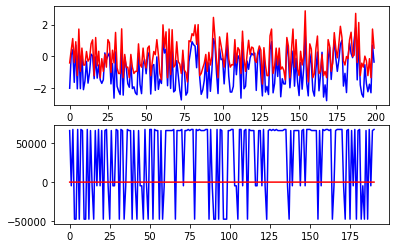

In [50]:
plt.subplot(211)
plt.plot(y_pre_tr, 'b-')
plt.plot(ytrain, 'r')
plt.subplot(212)
plt.plot(y_pre_te, 'b')
plt.plot(ytest, 'r')
plt.show()

## Regression using in-built function

In [32]:
def polynomialmodel(X, Q):
        row, columns = X.shape
        phi = deque()
        phi.append(np.ones(row))
        for degree in range(1, Q+1):
            for col in range(columns):
                phi.append(X[:,col]**degree)
        return np.array(phi).T

In [33]:
phi_train = polynomialmodel(Xtrain, Q=2)
phi_test = polynomialmodel(Xtest, Q=2)

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model = LinearRegression()
model.fit(phi_train, ytrain)

LinearRegression()

In [38]:
model.coef_

array([[ 0.        ,  0.16401597, -0.30346561, -0.24425114, -0.47590338,
        -0.12942746,  0.37492437,  0.12850362, -0.09562763,  0.06226233,
         0.03555481,  0.15037776,  0.07354542,  0.11693968, -0.09838035]])

In [39]:
model.intercept_

array([-0.24467202])

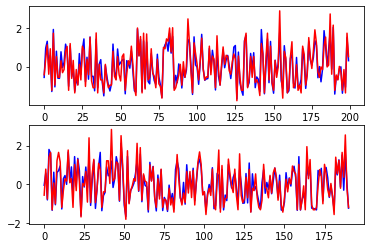

In [37]:
y_pre_tr = model.predict(phi_train)
y_pre_te = model.predict(phi_test)
plt.subplot(211)
plt.plot(y_pre_tr, 'b-')
plt.plot(ytrain, 'r')
plt.subplot(212)
plt.plot(y_pre_te, 'b')
plt.plot(ytest, 'r')
plt.show()


## Regularization

In [59]:
model = Regularization(landa=0.0001, kernel_type='poly')
model.fit(Xtrain, ytrain, Q=10)

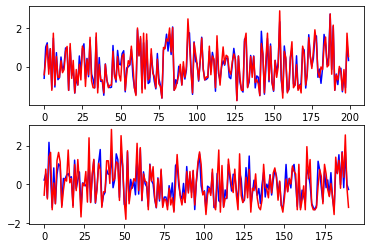

In [60]:
y_pre_tr = model.predict(Xtrain)
y_pre_te = model.predict(Xtest)
plt.subplot(211)
plt.plot(y_pre_tr, 'b-')
plt.plot(ytrain, 'r')
plt.subplot(212)
plt.plot(y_pre_te, 'b')
plt.plot(ytest, 'r')
plt.show()

## Curve fitting using built-in function

In [64]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.001)

In [65]:
model.fit(phi_train, ytrain)

Ridge(alpha=0.001)

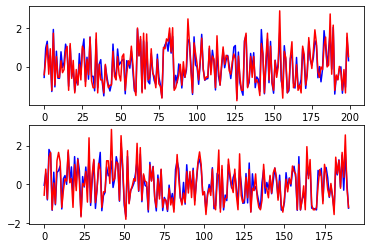

In [66]:
y_pre_tr = model.predict(phi_train)
y_pre_te = model.predict(phi_test)
plt.subplot(211)
plt.plot(y_pre_tr, 'b-')
plt.plot(ytrain, 'r')
plt.subplot(212)
plt.plot(y_pre_te, 'b')
plt.plot(ytest, 'r')
plt.show()